In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
fasta_content="D:\Repo\A_Universal_Framework_For_Clusetering_Sequences\Datasets\CPG_Island\Cpg_Dataset_Sequences.fa"

# Preprocessing: Extracting and encoding sequences
def parse_fasta(content):
    sequences = []
    labels = []
    max_len=0
    with open(content, 'r') as file:
        for line in file:
            if line.startswith("#"):
                label = line[-2]  # Assuming label is the last character of the line
                labels.append(label)
            else:
                if max_len < len(line.strip()):
                    max_len=len(line.strip())

                sequences.append(line.strip())
    
    return sequences, labels,max_len

# Extract sequences from the file
sequences,labels,max_len = parse_fasta(fasta_content)

In [3]:
def one_hot_encoding(seq,max_len):
    column_dim=max_len
    row_dim=5
    encoded_vector=np.zeros((row_dim,column_dim))
    i=0
    # Encoding sequences into numerical format (A=0, T=1, C=2, G=3)
    char_to_int = {'A': 0, 'T': 1, 'C': 2, 'G': 3}
    for i, chr in enumerate(seq):
        if chr in char_to_int:  # Check if the character is valid
            row_indx = char_to_int[chr]
            encoded_vector[row_indx][i] = 1

    return encoded_vector

encoded_sequences=[]

encoded_sequences = np.array([one_hot_encoding(seq, max_len) for seq in sequences])

In [4]:
encoded_sequences=encoded_sequences.reshape(len(encoded_sequences), -1)

print(encoded_sequences.shape)

(100000, 500)


In [5]:
# Preprocessing: Add a mapping for labels
label_to_int = {'0': 0, '1': 1}  # Example mapping; update based on your labels
numerical_labels = [label_to_int[label] for label in labels]  # Convert labels to numerical format
# Create a TensorDataset with both sequences and labels
padded_sequences_tensor = torch.tensor(encoded_sequences, dtype=torch.float32)
numerical_labels_tensor = torch.tensor(numerical_labels, dtype=torch.long)

In [6]:
# Combine sequences and labels into a TensorDataset
dataset = torch.utils.data.TensorDataset(padded_sequences_tensor, numerical_labels_tensor)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
# Modify the Autoencoder to return both encoded and decoded representations
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(500, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 2)   # Output 2 dimensions for latent space visualization
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,500),
            nn.Softmax(dim=1)
            # nn.Tanh()
        )

    def forward(self, x, output_file="softmax_ouput.txt"):
        with open(output_file, "w") as f:  # Open file to write
            f.write("Input Vector (first 5 rows):\n")
            # Format values to 2 decimal places and write them
            f.write(f"{self.format_tensor(x[:2])}\n\n")
            
            # Pass through encoder layers
            for i, layer in enumerate(self.encoder):
                x = layer(x)
                f.write(f"After Encoder Layer {i + 1} (first 5 rows):\n")
                f.write(f"{self.format_tensor(x[:2])}\n\n")
            
            # Save the encoded (latent) representation
            encoded = x
            f.write("Latent Representation (first 5 rows):\n")
            f.write(f"{self.format_tensor(encoded[:10])}\n\n")
            
            # Pass through decoder layers starting with `encoded`
            x = encoded
            for i, layer in enumerate(self.decoder):
                x = layer(x)
                f.write(f"After Decoder Layer {i + 1} (first 5 rows):\n")
                f.write(f"{self.format_tensor(x[:2])}\n\n")
            
            # Save the final decoded output
            decoded = x
            f.write("Output (Decoded) (first 5 rows):\n")
            f.write(f"{self.format_tensor(decoded[:2])}\n")
        
        return encoded, decoded

    def format_tensor(self, tensor):
        # Round the tensor values to 2 decimal places and return as a string
        return str(tensor.detach().cpu().numpy().round(2))

In [8]:
# Reinitialize the model for latent space visualization
input_dim = padded_sequences_tensor.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    for batch, _ in dataloader:  # Ignore labels during training
        optimizer.zero_grad()
        _, decoded = model(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

# Visualization: Extract latent points
model.eval()
latent_points = []
labels_list = []

with torch.no_grad():
    for batch, labels in dataloader:
        encoded, _ = model(batch)  # Extract encoded (latent) representations
        latent_points.append(encoded.numpy())  # Convert latent points to NumPy
        labels_list.append(labels.numpy())  # Convert labels to NumPy

# Combine latent points and labels for plotting
latent_points = np.concatenate(latent_points, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

Epoch: 1, Loss: 0.1252
Epoch: 2, Loss: 0.1274
Epoch: 3, Loss: 0.1191
Epoch: 4, Loss: 0.1300
Epoch: 5, Loss: 0.1181


In [9]:
# Check the shape after reshaping
print(latent_points.shape)  # Should be (100000, 2)
print(labels_list.shape)    # Should be (100000,)

(100000, 2)
(100000,)


In [10]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# latent_points_2d = pca.fit_transform(latent_points)

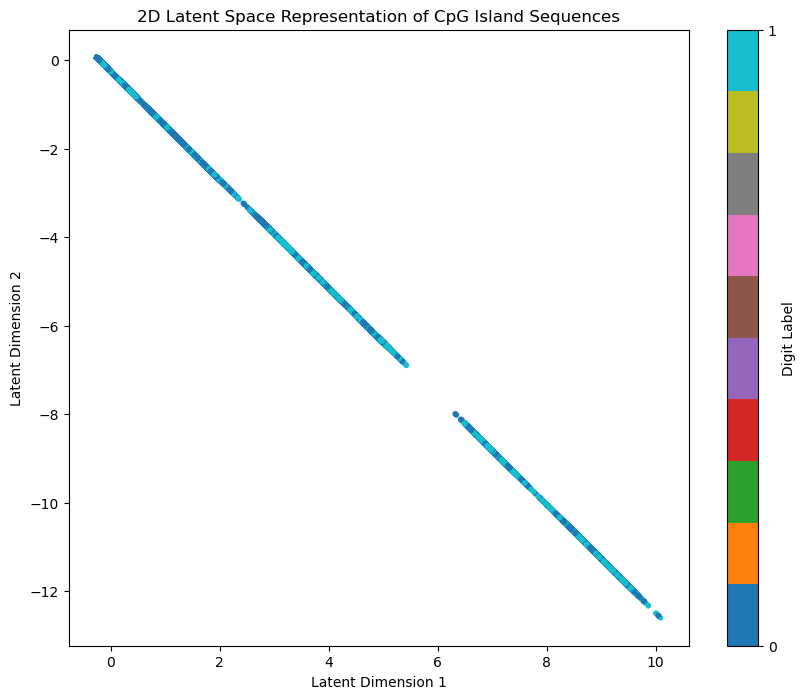

In [11]:
# Plot latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_points[:, 0], latent_points[:, 1], c=labels_list, cmap="tab10", s=10)
plt.colorbar(scatter, ticks=range(10), label="Digit Label")
plt.title("2D Latent Space Representation of CpG Island Sequences")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()

In [12]:
import torch
import torch.nn.functional as F

# Define a larger 2D sample vector with scientific notation
x = torch.tensor([
    [4.000e-02, 2.000e-02, 1.000e-02, 5.000e-02],
    [3.000e-02, 1.000e-02, -1.000e-02, -2.000e-02],
    [-3.000e-02, -4.000e-02, -5.000e-02, 2.000e-02],
    [1.000e-02, -3.000e-02, 3.000e-02, 4.000e-02],
    [2.000e-02, 1.000e-02, -2.000e-02, -1.000e-02],
    [5.000e-02, -1.000e-02, -3.000e-02, -4.000e-02]
])

# ReLU (Rectified Linear Unit)
relu_output = F.relu(x)
print("ReLU Output:", relu_output)

# Sigmoid
sigmoid_output = torch.sigmoid(x)
print("Sigmoid Output:", sigmoid_output)

# Tanh
tanh_output = torch.tanh(x)
print("Tanh Output:", tanh_output)

# Leaky ReLU
leaky_relu_output = F.leaky_relu(x)
print("Leaky ReLU Output:", leaky_relu_output)

# Softmax (using dim=1 for row-wise softmax)
softmax_output = F.softmax(x, dim=1)
print("Softmax Output:", softmax_output)


ReLU Output: tensor([[0.0400, 0.0200, 0.0100, 0.0500],
        [0.0300, 0.0100, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0200],
        [0.0100, 0.0000, 0.0300, 0.0400],
        [0.0200, 0.0100, 0.0000, 0.0000],
        [0.0500, 0.0000, 0.0000, 0.0000]])
Sigmoid Output: tensor([[0.5100, 0.5050, 0.5025, 0.5125],
        [0.5075, 0.5025, 0.4975, 0.4950],
        [0.4925, 0.4900, 0.4875, 0.5050],
        [0.5025, 0.4925, 0.5075, 0.5100],
        [0.5050, 0.5025, 0.4950, 0.4975],
        [0.5125, 0.4975, 0.4925, 0.4900]])
Tanh Output: tensor([[ 0.0400,  0.0200,  0.0100,  0.0500],
        [ 0.0300,  0.0100, -0.0100, -0.0200],
        [-0.0300, -0.0400, -0.0500,  0.0200],
        [ 0.0100, -0.0300,  0.0300,  0.0400],
        [ 0.0200,  0.0100, -0.0200, -0.0100],
        [ 0.0500, -0.0100, -0.0300, -0.0400]])
Leaky ReLU Output: tensor([[ 4.0000e-02,  2.0000e-02,  1.0000e-02,  5.0000e-02],
        [ 3.0000e-02,  1.0000e-02, -1.0000e-04, -2.0000e-04],
        [-3.0000e-04, -4.0000e-0